In [3]:
#%pip install scipy==1.11.4

In [4]:
import pandas as pd
import numpy as np
import os
import pickle

from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.tree import export_graphviz


from functions.missclassification_rate import missclassification_rate
from functions.extract_original_feature_name import extract_original

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data and model imports

In [6]:
path = os.getcwd() + '/data'
X_test = pd.read_csv(path + '/X_test.csv')
y_test = pd.read_csv(path + '/y_test.csv')
X_train = pd.read_csv(path + '/X_train.csv')
y_train = pd.read_csv(path + '/y_train.csv')

# Evaluation

## Initialization of lists for results table

In [7]:
model_name_result = ['Logistic Regression (undersample)', 'Logistic Regression (oversample)', 'Random forest (undersample)', 'Random forest (oversample)',
         'XGB (undersample)', 'XGB (oversample)', 'LGB (undersample)', 'LGB (oversample)']
recall_result = []
precision_result = []
f1_result = []
acc_result = []
ks_result = []
roc_auc_result = []
pr_auc_result = []
miss_rate_result = []
acc_diff_result = []
recall_diff_result = []
fn_cnt = []

## Logistic Regression

In [8]:
with open('models/under_lr.pkl', 'rb') as f:
    u_lr = pickle.load(f)
f.close()

with open('models/over_lr.pkl', 'rb') as f:
    o_lr = pickle.load(f)
f.close()

### Predictions

In [9]:
lr_under_y_pred = u_lr.predict(X_test)
lr_over_y_pred = o_lr.predict(X_test)

lr_under_y_pred_proba = u_lr.predict_proba(X_test)
lr_over_y_pred_proba =o_lr.predict_proba(X_test)

under_train_pred = u_lr.predict(X_train)
over_train_pred = o_lr.predict(X_train)
under_train_pred_proba = u_lr.predict_proba(X_train)
over_train_pred_proba = o_lr.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_75399/2786963175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


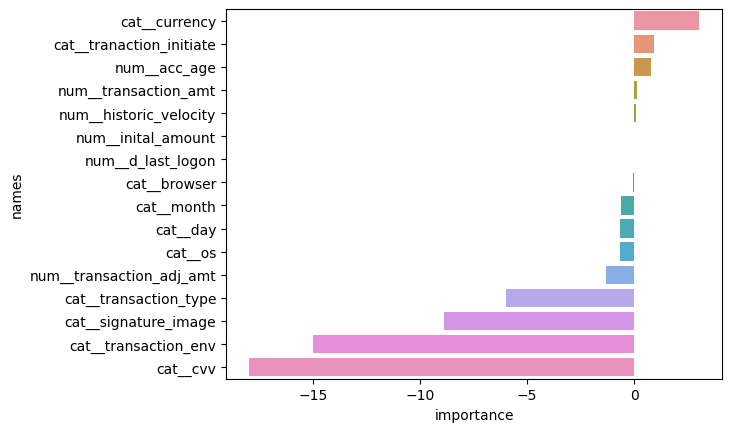

                       names  importance
1              cat__currency    3.036383
7   cat__tranaction_initiate    0.923700
10              num__acc_age    0.785269
15      num__transaction_amt    0.141596
12    num__historic_velocity    0.069259
13        num__inital_amount   -0.006064
11         num__d_last_logon   -0.020717
0               cat__browser   -0.074365
4                 cat__month   -0.624450
3                   cat__day   -0.682777
5                    cat__os   -0.688268
14  num__transaction_adj_amt   -1.325115
9      cat__transaction_type   -5.992006
6       cat__signature_image   -8.894449
8       cat__transaction_env  -15.010227
2                   cat__cvv  -17.997307


In [10]:
coef = list(u_lr.best_estimator_.named_steps['LogReg'].coef_)
f_names = list(u_lr.best_estimator_[:-1].get_feature_names_out())
imp_temp  = pd.DataFrame({'names': f_names, 'importance': coef[0]}).sort_values(by='importance', ascending=False)

cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_75399/1410451271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


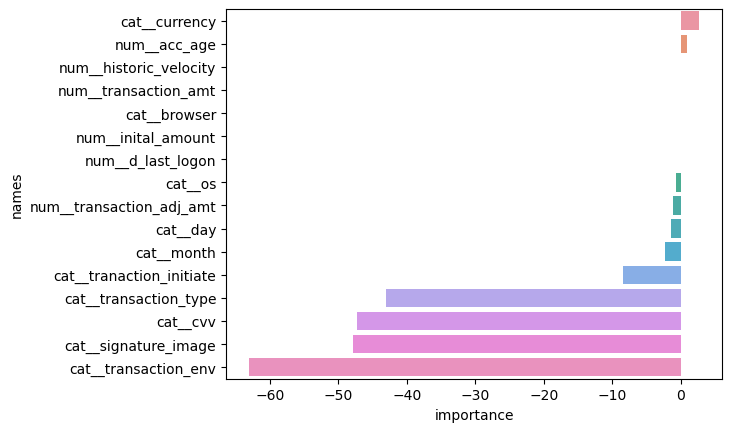

                       names  importance
1              cat__currency    2.725243
10              num__acc_age    0.973888
12    num__historic_velocity    0.094293
15      num__transaction_amt    0.091116
0               cat__browser    0.020777
13        num__inital_amount   -0.005969
11         num__d_last_logon   -0.015584
5                    cat__os   -0.695168
14  num__transaction_adj_amt   -1.177301
3                   cat__day   -1.463551
4                 cat__month   -2.262203
7   cat__tranaction_initiate   -8.441409
9      cat__transaction_type  -43.033764
2                   cat__cvv  -47.244854
6       cat__signature_image  -47.807519
8       cat__transaction_env  -63.111540


In [11]:
coef = list(o_lr.best_estimator_.named_steps['LogReg'].coef_)
f_names = list(o_lr.best_estimator_[:-1].get_feature_names_out())
imp_temp  = pd.DataFrame({'names': f_names, 'importance': coef[0]}).sort_values(by='importance', ascending=False)

cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [12]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lr_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}, loc: {ks.statistic_location}")
loc_under_lr = ks.statistic_location
ks_result.append(ks.statistic)

0.7708 p-value: 0.000e+00, loc: 0.5612250094354373


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


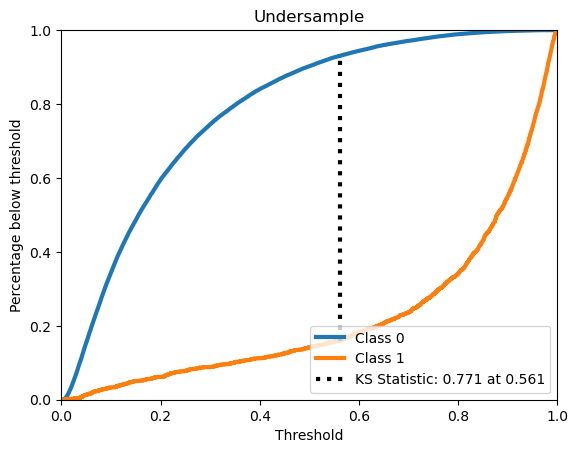

In [13]:
skplt.metrics.plot_ks_statistic(y_test, lr_under_y_pred_proba, title='Undersample')
plt.show()

In [14]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lr_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")
loc_over_lr = ks.statistic_location
ks_result.append(ks.statistic)



0.7696 p-value: 0.000e+00


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


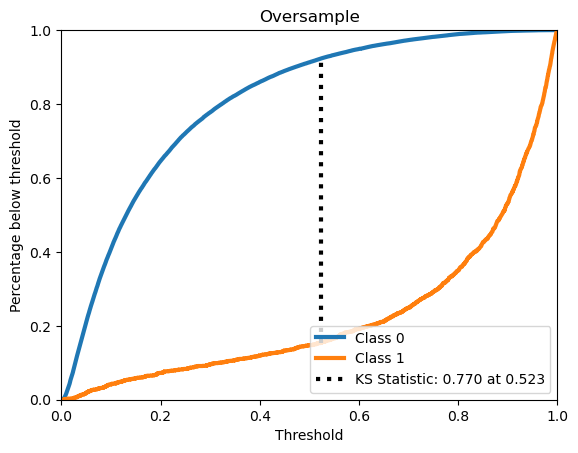

In [15]:
skplt.metrics.plot_ks_statistic(y_test, lr_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [16]:
lr_under_cut_off = loc_under_lr
lr_over_cut_off = loc_over_lr
lr_over_y_pred_proba_class = np.where(lr_over_y_pred_proba[:, 1] > lr_under_cut_off, 1, 0)
lr_under_y_pred_proba_class = np.where(lr_under_y_pred_proba[:, 1] > lr_over_cut_off, 1, 0)

### Precision-Recall Curve

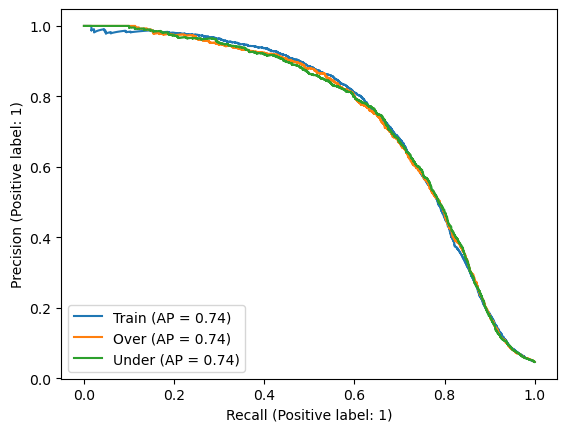

In [17]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

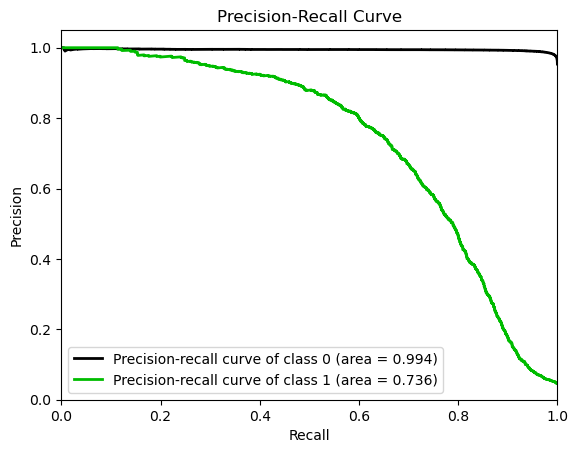

In [18]:
skplt.metrics.plot_precision_recall(y_test, lr_over_y_pred_proba, plot_micro=False)

### Confussion matrix

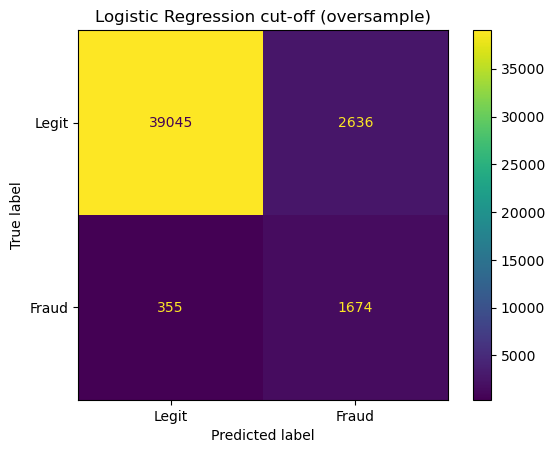

In [19]:
lr_cm_over = confusion_matrix(y_test, lr_over_y_pred_proba_class)
lr_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm_over, display_labels = ['Legit', 'Fraud'])
lr_cm_over_display.plot()
plt.title('Logistic Regression cut-off (oversample)')
plt.show()

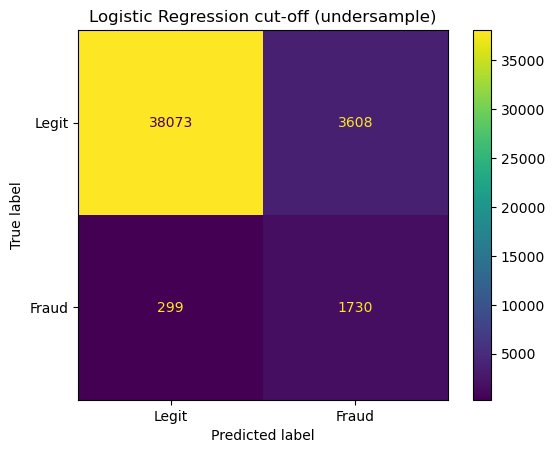

In [20]:
lr_cm_under = confusion_matrix(y_test, lr_under_y_pred_proba_class)
lr_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm_under, display_labels = ['Legit', 'Fraud'])
lr_cm_under_display.plot()
plt.title('Logistic Regression cut-off (undersample)')
plt.show()

In [21]:
fn_cnt.append((lr_cm_under[1][0]))
fn_cnt.append((lr_cm_over[1][0]))

### Cumulative Gain

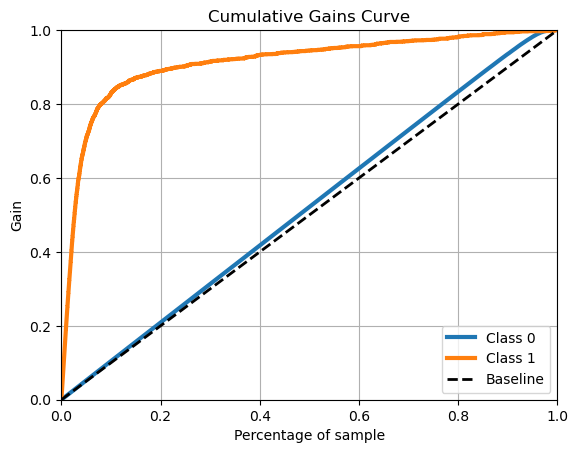

In [22]:
skplt.metrics.plot_cumulative_gain(y_test, lr_over_y_pred_proba)
plt.show()

### ROC

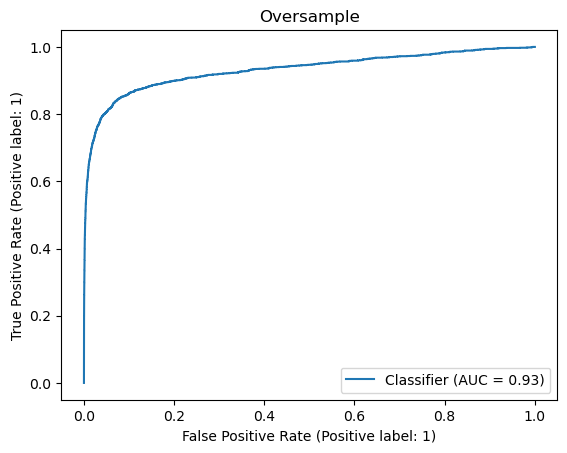

In [23]:
RocCurveDisplay.from_predictions(
    y_test, lr_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [24]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, lr_over_y_pred_proba_class)}')

Accuracy Train: 0.9083911832764638 Test: 0.9315717227179136


In [25]:
print(classification_report(y_test, lr_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     41681
           1       0.39      0.83      0.53      2029

    accuracy                           0.93     43710
   macro avg       0.69      0.88      0.75     43710
weighted avg       0.96      0.93      0.94     43710



In [26]:
print(f'The missclasification rate is: {missclassification_rate(y_test, lr_over_y_pred)}')

The missclasification rate is: 0.08997940974605353


# Random Forest

In [27]:
with open('models/under_rf.pkl', 'rb') as f:
    u_rf = pickle.load(f)
f.close()

with open('models/over_rf.pkl', 'rb') as f:
    o_rf = pickle.load(f)
f.close()

### Predictions

In [28]:
rf_under_y_pred = u_rf.predict(X_test)
rf_over_y_pred = o_rf.predict(X_test)

rf_under_y_pred_proba = u_rf.predict_proba(X_test)
rf_over_y_pred_proba =o_rf.predict_proba(X_test)

under_train_pred = u_rf.predict(X_train)
over_train_pred = o_rf.predict(X_train)
under_train_pred_proba = u_rf.predict_proba(X_train)
over_train_pred_proba = o_rf.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categ

In [95]:
importances = list(u_rf.best_estimator_.named_steps['RandomForest'].feature_importances_)
f_names = list(u_rf.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
imp_temp

,names,importance
151,num__transaction_adj_amt,0.460728
154,num__acc_age,0.118914
150,num__transaction_amt,0.087532
152,num__historic_velocity,0.027568
9,cat__cvv_H,0.020595
20,cat__cvv_S,0.016365
23,cat__cvv_V,0.015315
72,cat__transaction_type_X,0.013473
52,cat__transaction_type_C,0.013190
94,cat__transaction_env_V,0.012520


/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_75399/167288925.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


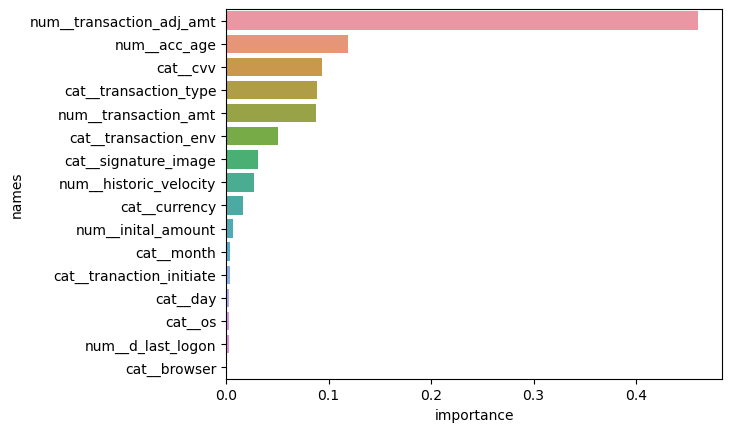

                       names  importance
14  num__transaction_adj_amt    0.460728
10              num__acc_age    0.118914
2                   cat__cvv    0.093679
9      cat__transaction_type    0.088905
15      num__transaction_amt    0.087532
8       cat__transaction_env    0.050509
6       cat__signature_image    0.031626
12    num__historic_velocity    0.027568
1              cat__currency    0.016802
13        num__inital_amount    0.006617
4                 cat__month    0.003694
7   cat__tranaction_initiate    0.003612
3                   cat__day    0.003266
5                    cat__os    0.003252
11         num__d_last_logon    0.002442
0               cat__browser    0.000855


In [30]:
importances = list(u_rf.best_estimator_.named_steps['RandomForest'].feature_importances_)
f_names = list(u_rf.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_75399/45559779.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


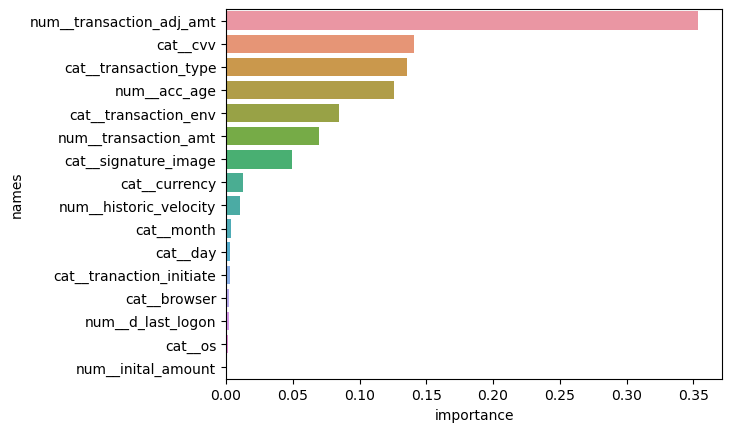

                       names  importance
14  num__transaction_adj_amt    0.353798
2                   cat__cvv    0.141156
9      cat__transaction_type    0.135357
10              num__acc_age    0.125971
8       cat__transaction_env    0.084939
15      num__transaction_amt    0.069937
6       cat__signature_image    0.049330
1              cat__currency    0.012744
12    num__historic_velocity    0.010127
4                 cat__month    0.004010
3                   cat__day    0.003001
7   cat__tranaction_initiate    0.002894
0               cat__browser    0.002472
11         num__d_last_logon    0.002348
5                    cat__os    0.001500
13        num__inital_amount    0.000416


In [31]:
importances = list(o_rf.best_estimator_.named_steps['RandomForest'].feature_importances_)
f_names = list(o_rf.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [32]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = rf_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}, loc: {ks.statistic_location}")
loc_under_rf = ks.statistic_location
ks_result.append(ks.statistic)

0.7578 p-value: 0.000e+00, loc: 0.46505898104365884


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


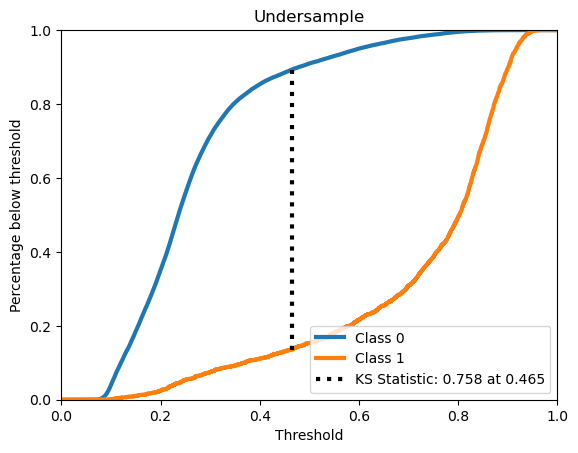

In [33]:
skplt.metrics.plot_ks_statistic(y_test, rf_under_y_pred_proba, title='Undersample')
plt.show()

In [34]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = rf_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_over_rf = ks.statistic_location
ks_result.append(ks.statistic)

0.7556 p-value: 0.000e+00 loc: 0.39466124386944484


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


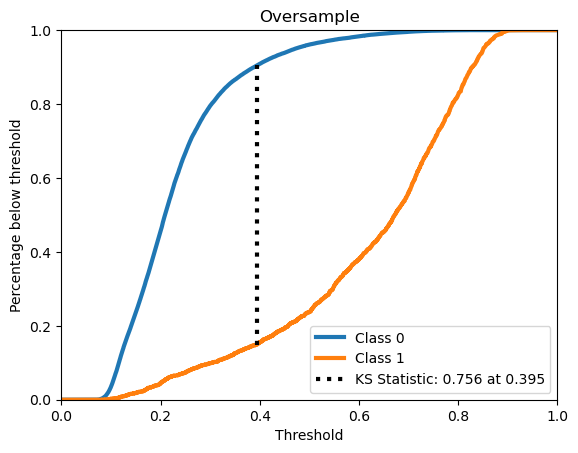

In [35]:
skplt.metrics.plot_ks_statistic(y_test, rf_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [36]:
rf_under_cut_off = loc_under_rf
rf_over_cut_off = loc_over_rf
rf_over_y_pred_proba_class = np.where(rf_over_y_pred_proba[:, 1] > rf_under_cut_off, 1, 0)
rf_under_y_pred_proba_class = np.where(rf_under_y_pred_proba[:, 1] > rf_over_cut_off, 1, 0)

### Precision-Recall Curve

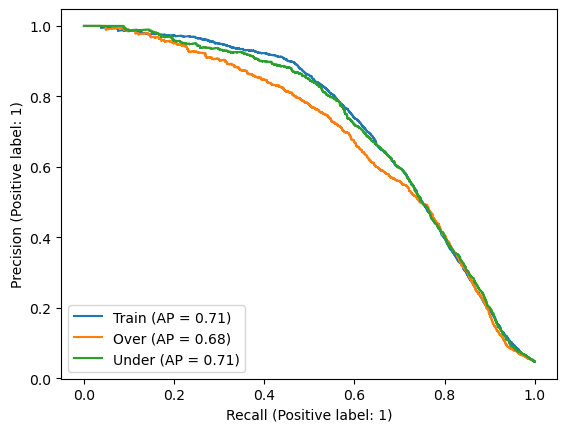

In [37]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

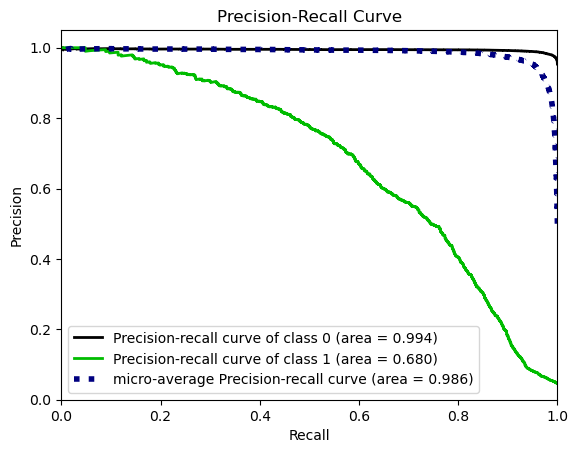

In [38]:
skplt.metrics.plot_precision_recall(y_test, rf_over_y_pred_proba)

### Confussion matrix

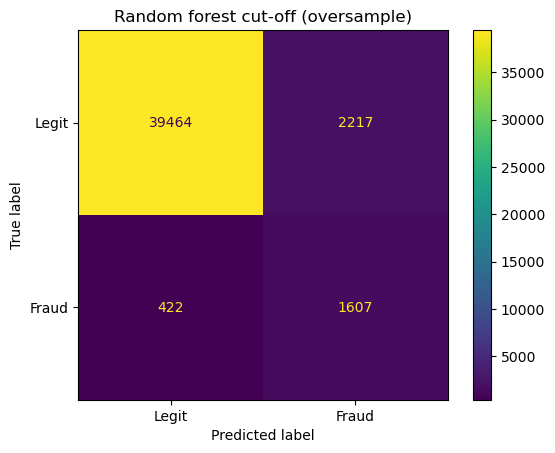

In [39]:
rf_cm_over = confusion_matrix(y_test, rf_over_y_pred_proba_class)
rf_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm_over, display_labels = ['Legit', 'Fraud'])
rf_cm_over_display.plot()
plt.title('Random forest cut-off (oversample)')
plt.show()

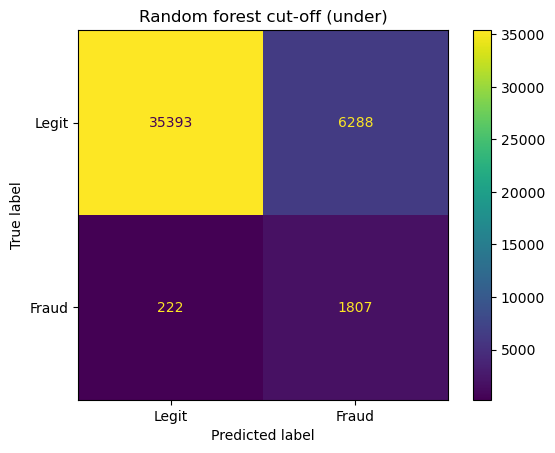

In [40]:
rf_cm_under = confusion_matrix(y_test, rf_under_y_pred_proba_class)
rf_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm_under, display_labels = ['Legit', 'Fraud'])
rf_cm_under_display.plot()
plt.title('Random forest cut-off (under)')
plt.show()

In [41]:
fn_cnt.append((rf_cm_under[1][0]))
fn_cnt.append((rf_cm_over[1][0]))

### Cumulative Gain

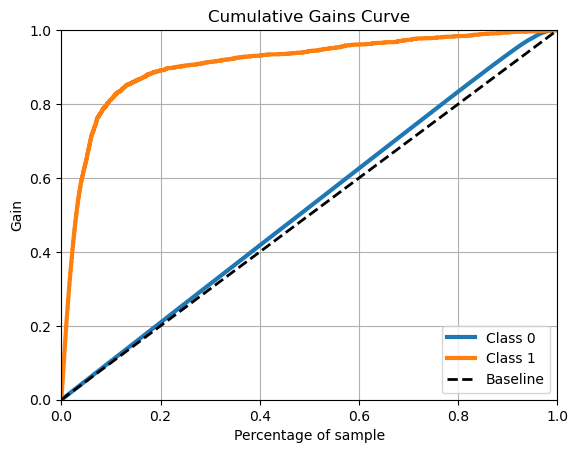

In [42]:
skplt.metrics.plot_cumulative_gain(y_test, rf_over_y_pred_proba)
plt.show()

### ROC

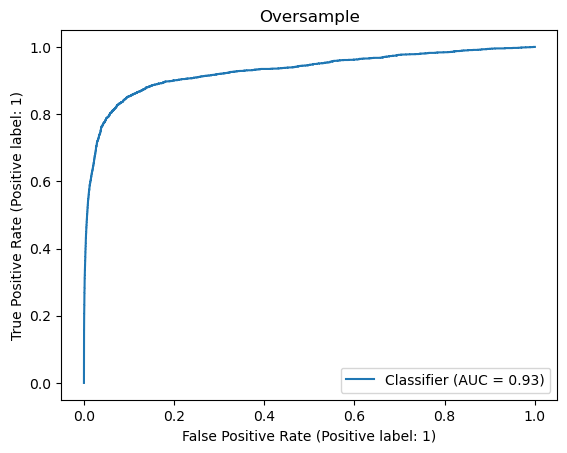

In [43]:
RocCurveDisplay.from_predictions(
    y_test, rf_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [44]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, rf_over_y_pred_proba_class)}')

Accuracy Train: 0.9497391850021571 Test: 0.9396247998169756


In [45]:
print(classification_report(y_test, rf_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     41681
           1       0.42      0.79      0.55      2029

    accuracy                           0.94     43710
   macro avg       0.70      0.87      0.76     43710
weighted avg       0.96      0.94      0.95     43710



In [46]:
print(f'The missclasification rate is: {missclassification_rate(y_test, rf_over_y_pred)}')

The missclasification rate is: 0.048272706474490966


### Example of tree from random forest

In [47]:
features = u_rf.best_estimator_[1].transformers_[0][1].get_feature_names_out().tolist()
features.extend(u_rf.best_estimator_[1].transformers_[1][1].get_feature_names_out().tolist())
export_graphviz(u_rf.best_estimator_[2].estimators_[1], out_file='img/tree.dot',rounded=True, precision=2, proportion=False, filled=True,feature_names=features )

# XGBoosting

In [48]:
with open('models/under_xgb.pkl', 'rb') as f:
    u_xgb = pickle.load(f)
f.close()

with open('models/over_xgb.pkl', 'rb') as f:
    o_xgb = pickle.load(f)
f.close()

### Predictions

In [49]:
xgb_under_y_pred = u_xgb.predict(X_test)
xgb_over_y_pred = o_xgb.predict(X_test)

xgb_under_y_pred_proba = u_xgb.predict_proba(X_test)
xgb_over_y_pred_proba =o_xgb.predict_proba(X_test)

under_train_pred = u_xgb.predict(X_train)
over_train_pred = o_xgb.predict(X_train)
under_train_pred_proba = u_xgb.predict_proba(X_train)
over_train_pred_proba = o_xgb.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_75399/1107856252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


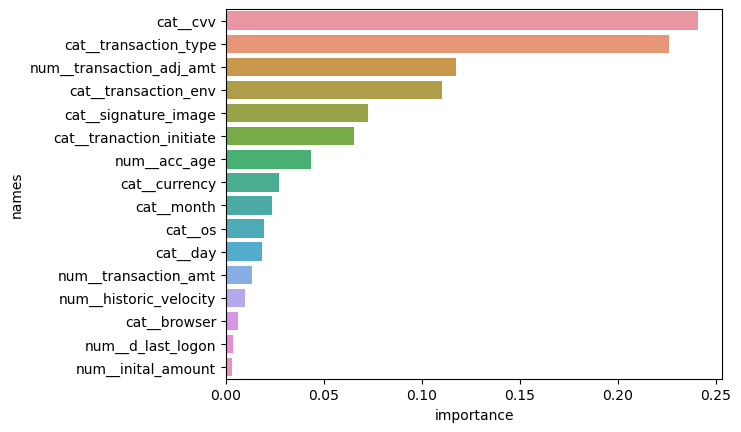

                       names  importance
2                   cat__cvv    0.241137
9      cat__transaction_type    0.226173
14  num__transaction_adj_amt    0.117217
8       cat__transaction_env    0.110005
6       cat__signature_image    0.072634
7   cat__tranaction_initiate    0.065517
10              num__acc_age    0.043591
1              cat__currency    0.026868
4                 cat__month    0.023406
5                    cat__os    0.019263
3                   cat__day    0.018517
15      num__transaction_amt    0.013019
12    num__historic_velocity    0.009566
0               cat__browser    0.006112
11         num__d_last_logon    0.003697
13        num__inital_amount    0.003278


In [50]:
importances = list(u_xgb.best_estimator_.named_steps['XGB'].feature_importances_)
f_names = list(u_xgb.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_75399/1966249323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


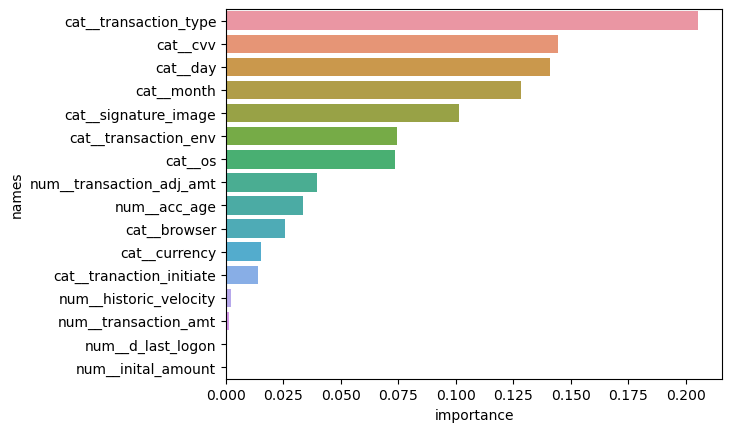

                       names  importance
9      cat__transaction_type    0.205489
2                   cat__cvv    0.144281
3                   cat__day    0.140863
4                 cat__month    0.128204
6       cat__signature_image    0.101251
8       cat__transaction_env    0.074404
5                    cat__os    0.073521
14  num__transaction_adj_amt    0.039630
10              num__acc_age    0.033288
0               cat__browser    0.025490
1              cat__currency    0.015355
7   cat__tranaction_initiate    0.013991
12    num__historic_velocity    0.002048
15      num__transaction_amt    0.001454
11         num__d_last_logon    0.000378
13        num__inital_amount    0.000351


In [51]:
importances = list(o_xgb.best_estimator_.named_steps['XGB'].feature_importances_)
f_names = list(o_xgb.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [52]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = xgb_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_under_xgb = ks.statistic_location
ks_result.append(ks.statistic)

0.8040 p-value: 0.000e+00 loc: 0.5283915400505066


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


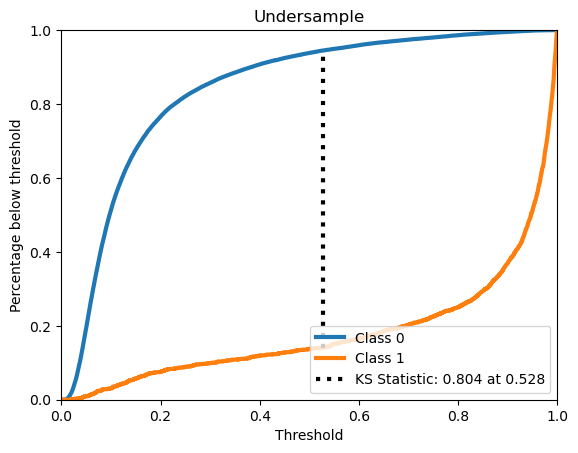

In [53]:
skplt.metrics.plot_ks_statistic(y_test, xgb_under_y_pred_proba, title='Undersample')
plt.show()

In [54]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = xgb_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_over_xgb = ks.statistic_location
ks_result.append(ks.statistic)

0.8307 p-value: 0.000e+00 loc: 0.06167266145348549


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


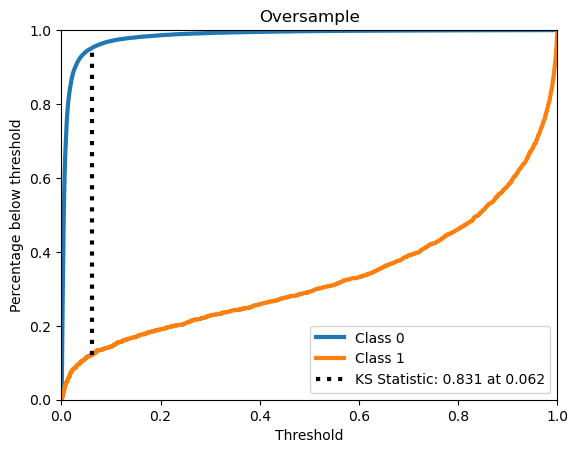

In [55]:
skplt.metrics.plot_ks_statistic(y_test, xgb_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [56]:
xgb_under_cut_off = loc_under_xgb
xgb_over_cut_off = loc_over_xgb
xgb_over_y_pred_proba_class = np.where(xgb_over_y_pred_proba[:, 1] > xgb_under_cut_off, 1, 0)
xgb_under_y_pred_proba_class = np.where(xgb_under_y_pred_proba[:, 1] > xgb_over_cut_off, 1, 0)

### Precision-Recall Curve

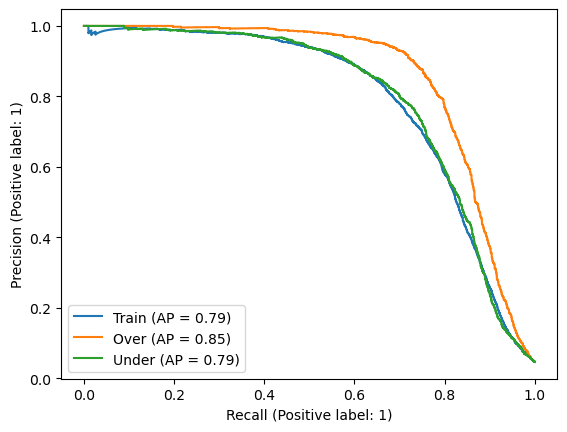

In [57]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

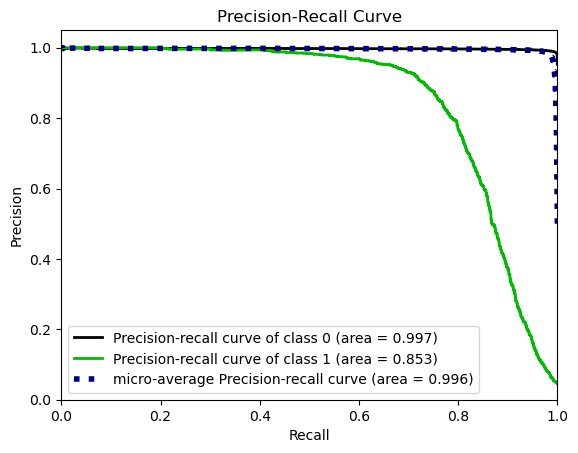

In [58]:
skplt.metrics.plot_precision_recall(y_test, xgb_over_y_pred_proba)

### Confussion matrix

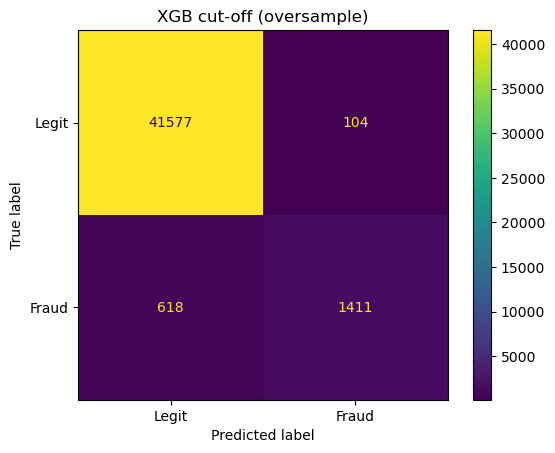

In [59]:
xgb_cm_over = confusion_matrix(y_test, xgb_over_y_pred_proba_class)
xgb_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = xgb_cm_over, display_labels = ['Legit', 'Fraud'])
xgb_cm_over_display.plot()
plt.title('XGB cut-off (oversample)')
plt.show()

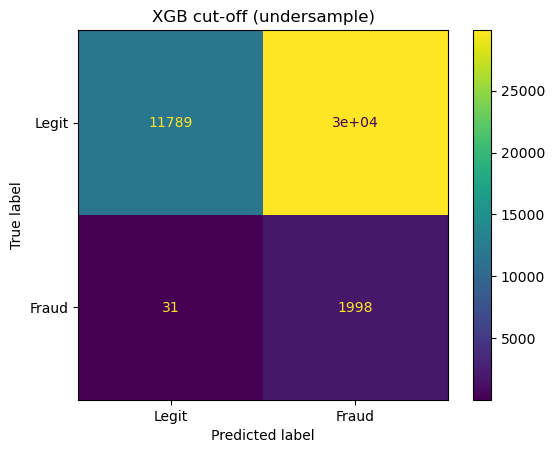

In [60]:
xgb_cm_under = confusion_matrix(y_test, xgb_under_y_pred_proba_class)
xgb_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = xgb_cm_under, display_labels = ['Legit', 'Fraud'])
xgb_cm_under_display.plot()
plt.title('XGB cut-off (undersample)')
plt.show()

In [61]:
fn_cnt.append((xgb_cm_under[1][0]))
fn_cnt.append((xgb_cm_over[1][0]))

### Cumulative Gain

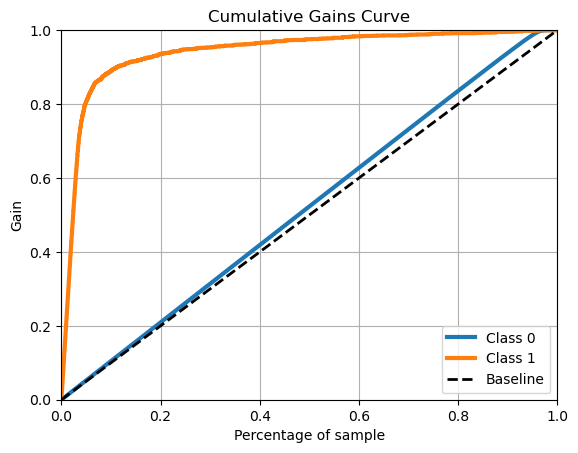

In [62]:
skplt.metrics.plot_cumulative_gain(y_test, xgb_over_y_pred_proba)
plt.show()

### ROC

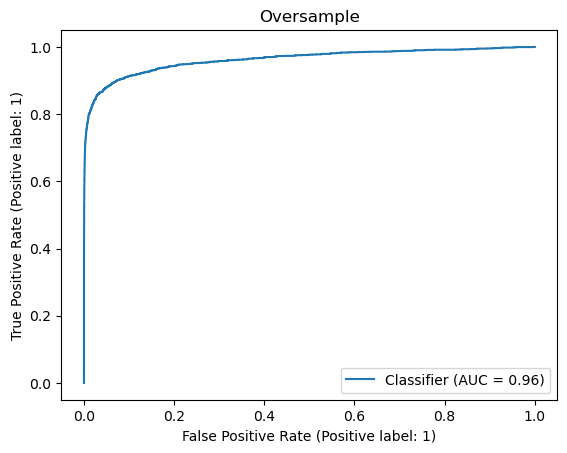

In [63]:
RocCurveDisplay.from_predictions(
    y_test, xgb_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [64]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, xgb_over_y_pred_proba_class)}')

Accuracy Train: 0.9825469663097619 Test: 0.9834820407229466


In [65]:
print(classification_report(y_test, xgb_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     41681
           1       0.93      0.70      0.80      2029

    accuracy                           0.98     43710
   macro avg       0.96      0.85      0.89     43710
weighted avg       0.98      0.98      0.98     43710



In [66]:
print(f'The missclasification rate is: {missclassification_rate(y_test, xgb_over_y_pred)}')

The missclasification rate is: 0.016129032258064516


# LGBoosting

In [67]:
with open('models/under_lgb.pkl', 'rb') as f:
    u_lgb = pickle.load(f)
f.close()

with open('models/over_lgb.pkl', 'rb') as f:
    o_lgb = pickle.load(f)
f.close()

### Predictions

In [68]:
lgb_under_y_pred = u_lgb.predict(X_test)
lgb_over_y_pred = o_lgb.predict(X_test)

lgb_under_y_pred_proba = u_lgb.predict_proba(X_test)
lgb_over_y_pred_proba =o_lgb.predict_proba(X_test)

under_train_pred = u_lgb.predict(X_train)
over_train_pred = o_lgb.predict(X_train)
under_train_pred_proba = u_lgb.predict_proba(X_train)
over_train_pred_proba = o_lgb.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transf

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_75399/1819173728.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


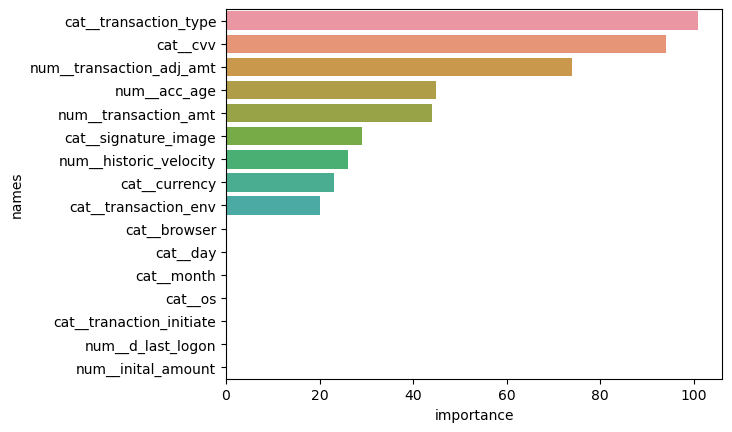

                       names  importance
9      cat__transaction_type         101
2                   cat__cvv          94
14  num__transaction_adj_amt          74
10              num__acc_age          45
15      num__transaction_amt          44
6       cat__signature_image          29
12    num__historic_velocity          26
1              cat__currency          23
8       cat__transaction_env          20
0               cat__browser           0
3                   cat__day           0
4                 cat__month           0
5                    cat__os           0
7   cat__tranaction_initiate           0
11         num__d_last_logon           0
13        num__inital_amount           0


In [69]:
importances = list(u_lgb.best_estimator_.named_steps['LGB'].feature_importances_)
f_names = list(u_lgb.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_75399/3948416697.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


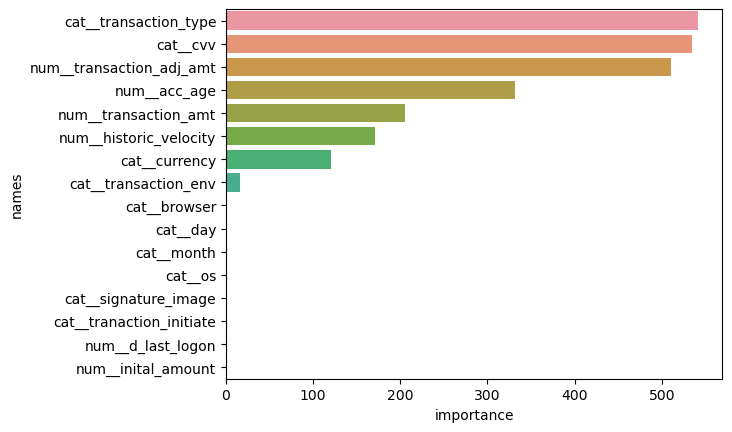

                       names  importance
9      cat__transaction_type         542
2                   cat__cvv         535
14  num__transaction_adj_amt         511
10              num__acc_age         331
15      num__transaction_amt         205
12    num__historic_velocity         171
1              cat__currency         121
8       cat__transaction_env          16
0               cat__browser           0
3                   cat__day           0
4                 cat__month           0
5                    cat__os           0
6       cat__signature_image           0
7   cat__tranaction_initiate           0
11         num__d_last_logon           0
13        num__inital_amount           0


In [70]:
importances = list(o_lgb.best_estimator_.named_steps['LGB'].feature_importances_)
f_names = list(o_lgb.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [71]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lgb_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_under_lgb = ks.statistic_location
ks_result.append(ks.statistic)

0.7318 p-value: 0.000e+00 loc: 0.4829471743764333


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


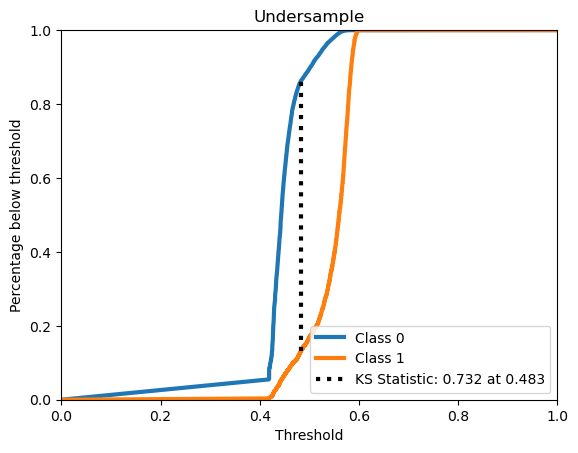

In [72]:
skplt.metrics.plot_ks_statistic(y_test, lgb_under_y_pred_proba, title='Undersample')
plt.show()

In [73]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lgb_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_over_lgb = ks.statistic_location
ks_result.append(ks.statistic)

0.7303 p-value: 0.000e+00 loc: 0.4794253800292426


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


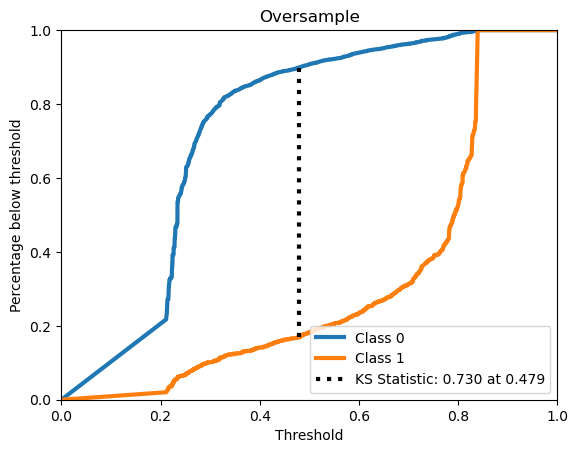

In [74]:
skplt.metrics.plot_ks_statistic(y_test, lgb_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [75]:
lgb_under_cut_off = loc_under_lgb
lgb_over_cut_off = loc_over_lgb
lgb_over_y_pred_proba_class = np.where(lgb_over_y_pred_proba[:, 1] > lgb_under_cut_off, 1, 0)
lgb_under_y_pred_proba_class = np.where(lgb_under_y_pred_proba[:, 1] > lgb_over_cut_off, 1, 0)

### Precision-Recall Curve

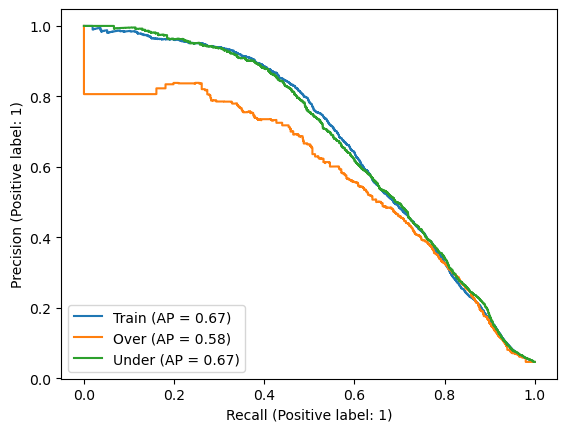

In [76]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

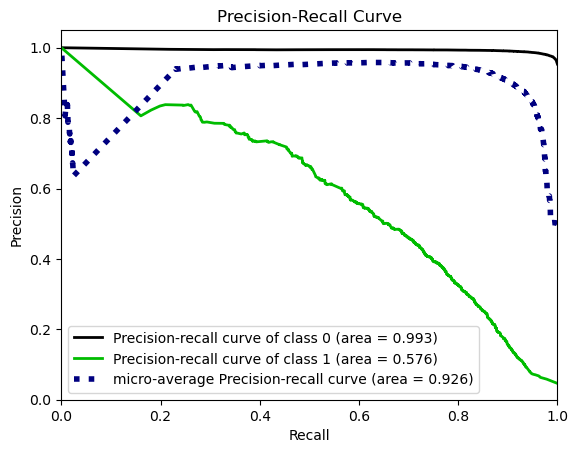

In [77]:
skplt.metrics.plot_precision_recall(y_test, lgb_over_y_pred_proba)

### Confussion matrix

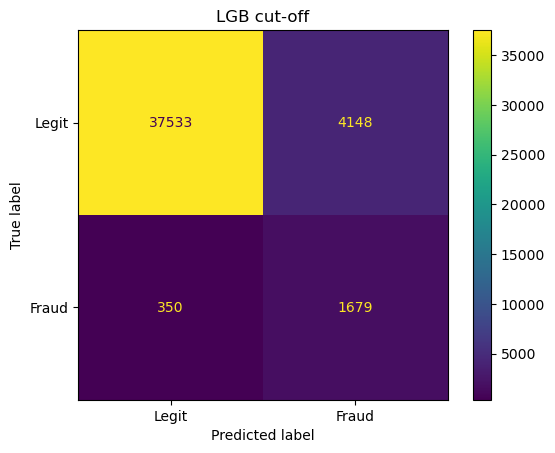

In [78]:
lgb_cm_over = confusion_matrix(y_test, lgb_over_y_pred_proba_class)
lgb_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = lgb_cm_over, display_labels = ['Legit', 'Fraud'])
lgb_cm_over_display.plot()
plt.title('LGB cut-off')
plt.show()

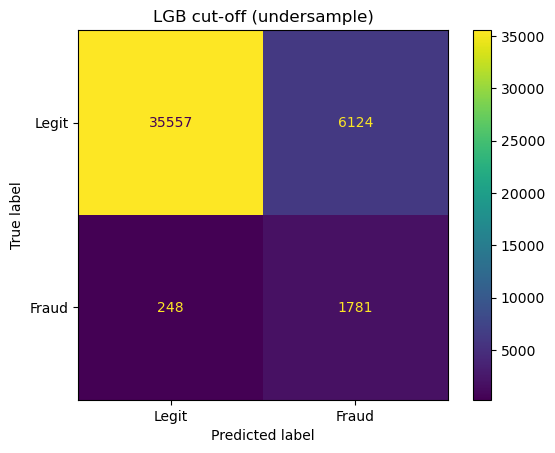

In [79]:
lgb_cm_under = confusion_matrix(y_test, lgb_under_y_pred_proba_class)
lgb_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = lgb_cm_under, display_labels = ['Legit', 'Fraud'])
lgb_cm_under_display.plot()
plt.title('LGB cut-off (undersample)')
plt.show()

In [80]:
fn_cnt.append((lgb_cm_under[1][0]))
fn_cnt.append((lgb_cm_over[1][0]))

### Cumulative Gain

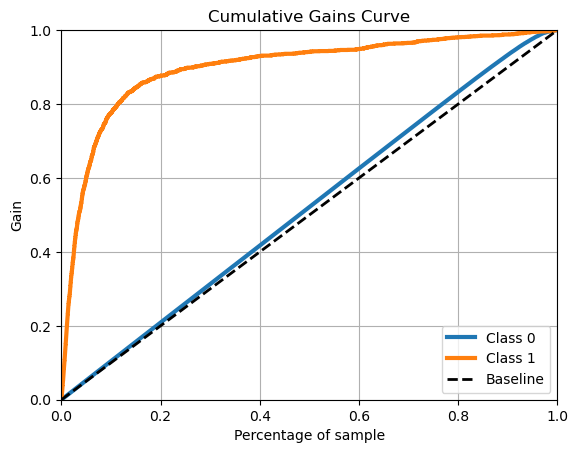

In [81]:
skplt.metrics.plot_cumulative_gain(y_test, lgb_over_y_pred_proba)
plt.show()

### ROC

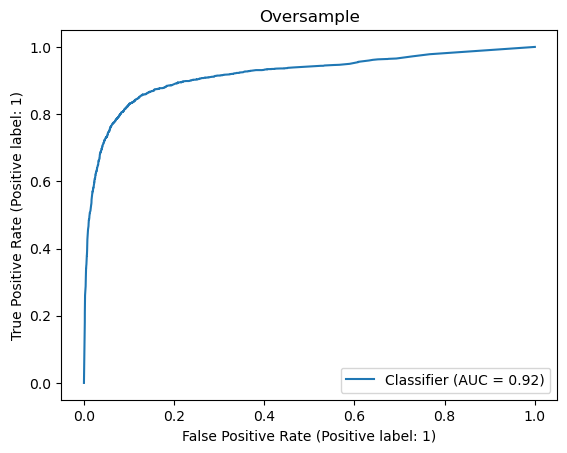

In [82]:
RocCurveDisplay.from_predictions(
    y_test, lgb_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [83]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, lgb_over_y_pred_proba_class)}')

Accuracy Train: 0.8999490136094442 Test: 0.8970944863875543


In [84]:
print(classification_report(y_test, lgb_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     41681
           1       0.29      0.83      0.43      2029

    accuracy                           0.90     43710
   macro avg       0.64      0.86      0.69     43710
weighted avg       0.96      0.90      0.92     43710



In [85]:
print(f'The missclasification rate is: {missclassification_rate(y_test, lgb_over_y_pred)}')

The missclasification rate is: 0.09681994966826814


# Aggregated Results

In [86]:
# Logistic Regression
recall_result.append(recall_score(y_test, lr_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, lr_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, lr_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, lr_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, lr_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, lr_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, lr_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, lr_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, lr_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, lr_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, lr_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, lr_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, lr_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, lr_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, lr_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, lr_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, lr_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, lr_over_y_pred_proba_class)))

In [87]:
# Random Forest
recall_result.append(recall_score(y_test, rf_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, rf_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, rf_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, rf_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, rf_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, rf_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, rf_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, rf_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, rf_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, rf_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, rf_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, rf_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, rf_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, rf_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, rf_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, rf_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, rf_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, rf_over_y_pred_proba_class)))

In [88]:
# XGB
recall_result.append(recall_score(y_test, xgb_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, xgb_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, xgb_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, xgb_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, xgb_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, xgb_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, xgb_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, xgb_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, xgb_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, xgb_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, xgb_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, xgb_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, xgb_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, xgb_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, xgb_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, xgb_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, xgb_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, xgb_over_y_pred_proba_class)))

In [89]:
# LGB
recall_result.append(recall_score(y_test, lgb_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, lgb_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, lgb_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, lgb_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, lgb_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, lgb_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, lgb_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, lgb_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, lgb_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, lgb_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, lgb_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, lgb_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, lgb_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, lgb_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, lgb_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, lgb_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, lgb_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, lgb_over_y_pred_proba_class)))

In [90]:
wyniki = pd.DataFrame(
    {'Model': model_name_result,'Recall': recall_result, 'Precision':precision_result,'F1': f1_result,
    'Accuracy': acc_result, 'KS' : ks_result, 'ROC_AUC': roc_auc_result,'PR_AUC': pr_auc_result,
    'Missclassification_rate': miss_rate_result, 'Acc_diff': acc_diff_result,'Recall_diff': recall_diff_result, 'False_negatives': fn_cnt}
    )


In [91]:
wyniki.sort_values(by='Recall', ascending=False)

,Model,Recall,Precision,F1,Accuracy,KS,ROC_AUC,PR_AUC,Missclassification_rate,Acc_diff,Recall_diff,False_negatives
4,XGB (undersample),0.984722,0.062653,0.117810,0.315420,0.804031,0.948635,0.794943,0.684580,0.574930,0.158359,31
2,Random forest (undersample),0.890586,0.223224,0.356974,0.851064,0.757846,0.934630,0.708799,0.148936,0.039286,0.064224,222
6,LGB (undersample),0.877772,0.225300,0.358567,0.854221,0.731777,0.924028,0.667920,0.145779,0.036129,0.051410,248
0,Logistic Regression (undersample),0.852637,0.324091,0.469662,0.910615,0.770763,0.931476,0.736554,0.089385,0.020266,0.026274,299
7,LGB (oversample),0.827501,0.288141,0.427444,0.897094,0.730271,0.917183,0.575626,0.102906,0.002855,0.014869,350
1,Logistic Regression (oversample),0.825037,0.388399,0.528159,0.931572,0.769613,0.931504,0.736342,0.068428,0.031623,0.012405,355
3,Random forest (oversample),0.792016,0.420241,0.549120,0.939625,0.755586,0.928310,0.680027,0.060375,0.039676,0.020616,422
5,XGB (oversample),0.695416,0.931353,0.796275,0.983482,0.830679,0.962460,0.853318,0.016518,0.083533,0.117216,618


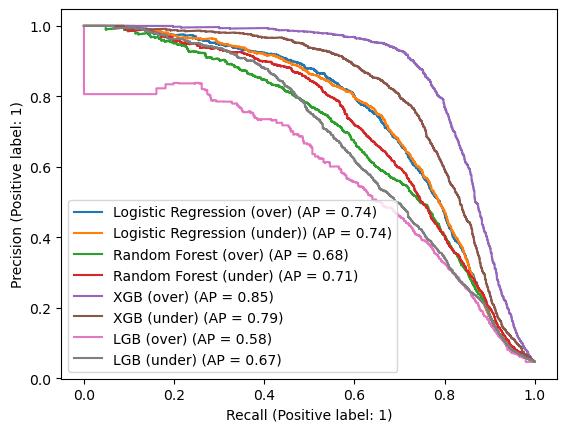

In [92]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name= "Logistic Regression (over)")
PrecisionRecallDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name="Logistic Regression (under))")

PrecisionRecallDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name= "Random Forest (over)")
PrecisionRecallDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name="Random Forest (under)")

PrecisionRecallDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name= "XGB (over)")
PrecisionRecallDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name="XGB (under)")

PrecisionRecallDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name= "LGB (over)")
PrecisionRecallDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name="LGB (under)")
plt.savefig("img/pr_result.png")
plt.show()

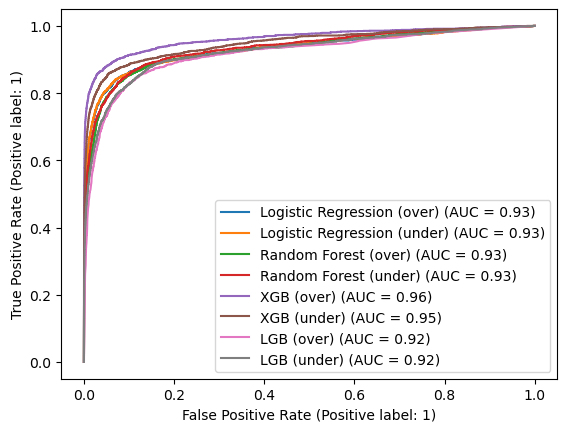

In [93]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name= 'Logistic Regression (over)')
RocCurveDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name='Logistic Regression (under)')

RocCurveDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name= 'Random Forest (over)')
RocCurveDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name='Random Forest (under)')

RocCurveDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name= 'XGB (over)')
RocCurveDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name='XGB (under)')

RocCurveDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name= 'LGB (over)')
RocCurveDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name='LGB (under)')
plt.show()

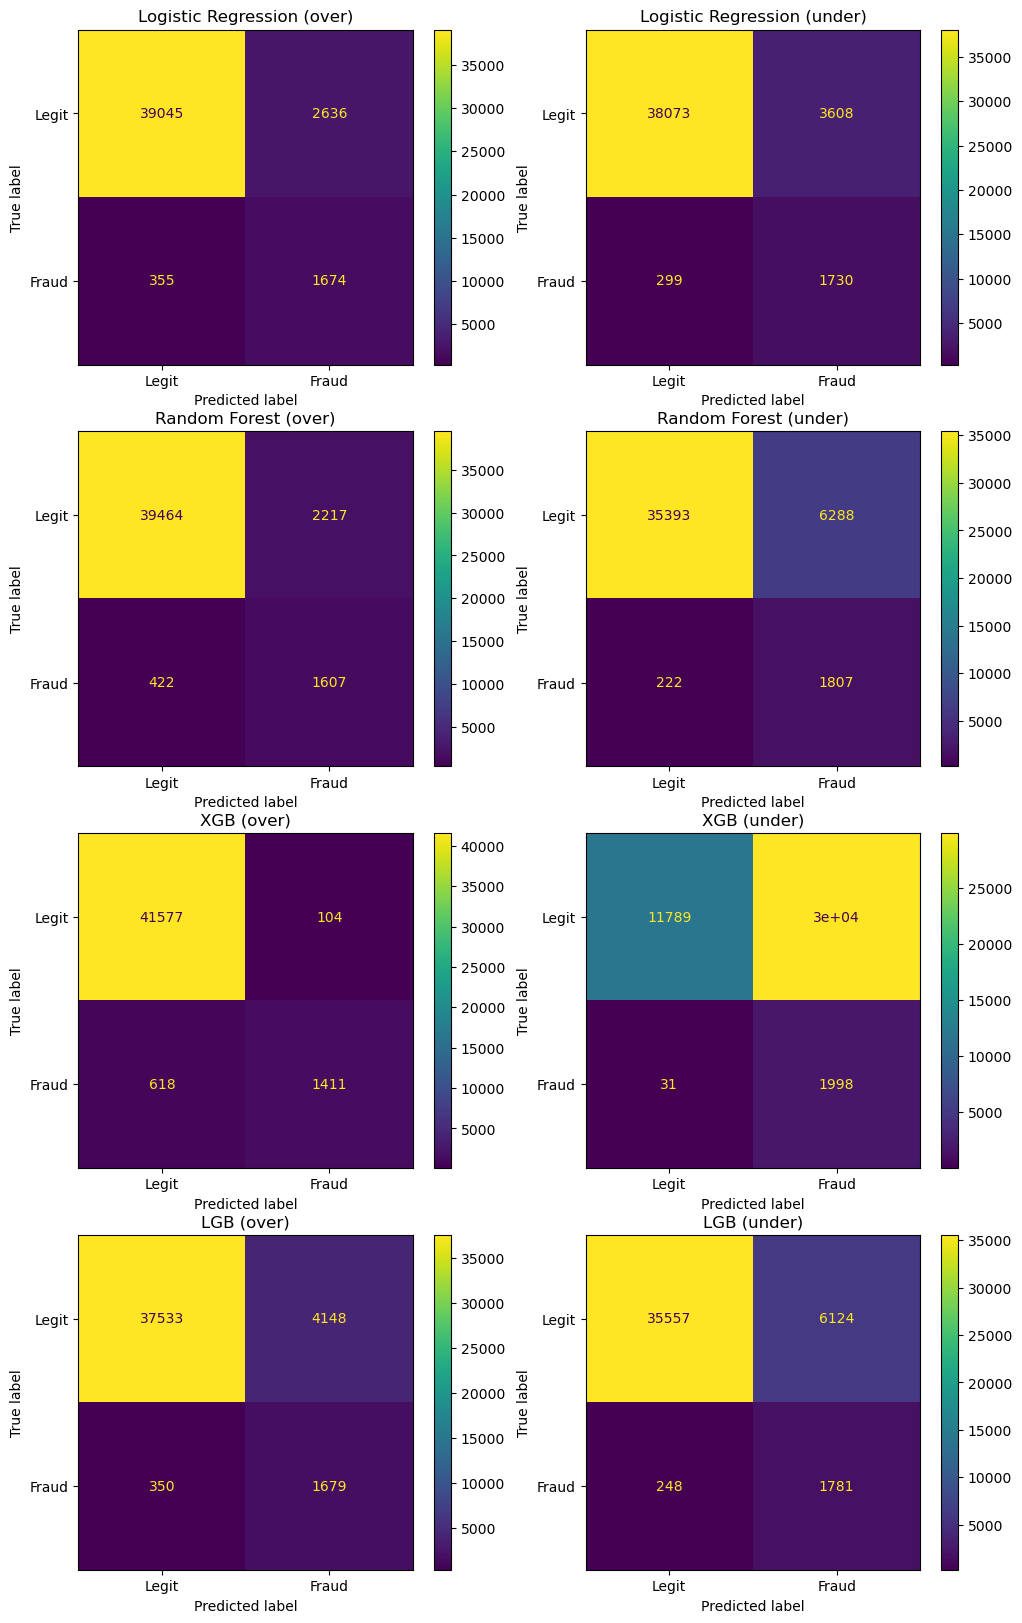

In [94]:
fig, axs = plt.subplots(4, 2, figsize=(12, 20))
lr_cm_over_display.plot(ax=axs[0][0])
axs[0][0].set_title('Logistic Regression (over)')
rf_cm_over_display.plot(ax=axs[1][0])
axs[1][0].set_title('Random Forest (over)')
xgb_cm_over_display.plot(ax=axs[2][0])
axs[2][0].set_title('XGB (over)')
lgb_cm_over_display.plot(ax=axs[3][0])
axs[3][0].set_title('LGB (over)')
lr_cm_under_display.plot(ax=axs[0][1])
axs[0][1].set_title('Logistic Regression (under)')
rf_cm_under_display.plot(ax=axs[1][1])
axs[1][1].set_title('Random Forest (under)')
xgb_cm_under_display.plot(ax=axs[2][1])
axs[2][1].set_title('XGB (under)')
lgb_cm_under_display.plot(ax=axs[3][1])
axs[3][1].set_title('LGB (under)')
plt.show()